In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
from torchtext import data
import re
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk
from gensim import corpora
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from torch.nn.utils.rnn import pad_packed_sequence
# alt.data_transformers.enable('data_server')
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
# from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
# from sklearn.compose import ColumnTransformer
# from sklearn.linear_model import LogisticRegression
# from sklearn.dummy import DummyClassifier
# from sklearn.utils import resample
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline as imbpipeline
# from sklearn.metrics import f1_score as f1
# from sklearn.metrics import confusion_matrix
# import torch
# from torch import nn
# import torch
# import torch.nn as nn
# from torch.utils.data import TensorDataset
# from torch.utils.data import DataLoader

# import math

### Import Data

In [2]:
df = pd.read_csv("twitter_training.csv", header = None)
df = df.drop([0, 1], axis = 1)
df = df.applymap(str)
df.columns = ["Sentiment", "Text"]
df["Target"] = df["Sentiment"].map({"Negative" : 0, "Positive" : 1, "Neutral" : 2, "Irrelevant" : 3})
df.head()

,Sentiment,Text,Target
0,Positive,im getting on borderlands and i will murder yo...,1
1,Positive,I am coming to the borders and I will kill you...,1
2,Positive,im getting on borderlands and i will kill you ...,1
3,Positive,im coming on borderlands and i will murder you...,1
4,Positive,im getting on borderlands 2 and i will murder ...,1


In [3]:
stopwords_eng = stopwords.words('english')

def preprocess_text(text):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    punct = "[^\w\s]+"
    text = re.sub(link_re_pattern, "", text)
    text = re.sub(punct, "", text)
    return text.lower()

def build_tweet_corpus(data):

    word_counter = build_tweet_counter(data)
    ls = []
    for key in word_counter:
        if word_counter[key] < 5:
            ls.append(key)
    
    stopwords = set(stopwords_eng + ls)
    tweet_corpus = set()
    for x in data:
        for word in x:
            if word not in stopwords:
                tweet_corpus.add(word)
    return list(tweet_corpus)

def build_tweet_counter(data):
    
    tweet_corpus = []
    for x in data:
        for word in x:
            if word not in stopwords_eng:
                tweet_corpus.append(word)
    return Counter(tweet_corpus)


def process_data(df):

    tokenizer = TweetTokenizer()

    df["Text"] = df["Text"].apply(preprocess_text)
    df["Tokens"] = df["Text"].apply(tokenizer.tokenize)
    df["Tokens"] = df["Tokens"].apply(lambda x: [word for word in x if word not in stopwords_eng])

    return df

def tokenize(df, tweet_corpus, max_len):
    corpus_dict = corpora.Dictionary([tweet_corpus]).token2id
    
    def to_tokenids(text):
        tokens = [corpus_dict[x] for x in text if x in corpus_dict]
        if len(tokens) <= 1:
            return "NA"
        else:
            return np.array(tokens)

    df["Tokens"] = df["Tokens"].apply(to_tokenids)
    df = df[df["Tokens"] != "NA"]
    lens = torch.LongTensor([len(x) for x in df["Tokens"]])

    def pad(x):
        if len(x) < max_len:
            x = np.append(x, [0]*(max_len - len(x)))
        return x[0:max_len]

    df['Tokens'] = df["Tokens"].apply(pad)
    return df, lens

In [4]:
df_processed = process_data(df)
traindata, valdata = train_test_split(df, test_size = 0.2, random_state= 321)

# length = df_processed["Tokens"].apply(len)
# plt.hist(length, bins = 30)

In [5]:
df_processed = process_data(df)
traindata, valdata = train_test_split(df, test_size = 0.2, random_state= 321)

train_corpus = build_tweet_corpus(df["Tokens"])

max_len = 35
traindata, trainlens = tokenize(traindata, train_corpus, 35)
valdata, vallens = tokenize(valdata, train_corpus, 35)


c:\Users\andy8\anaconda3\envs\stock_trade\lib\site-packages\pandas\core\ops\array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\andy8\AppData\Local\Temp\ipykernel_23836\3237871160.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'] = df["Tokens"].apply(pad)


In [6]:
trainX = np.stack(traindata["Tokens"])
trainY = np.array(traindata["Target"])
validX = np.stack(valdata["Tokens"])
validY = np.array(valdata["Target"])

In [7]:
torchtrain = TensorDataset(torch.from_numpy(trainX).to(torch.int64), torch.from_numpy(trainY).to(torch.int64))
torchtval = TensorDataset(torch.from_numpy(validX).to(torch.int64), torch.from_numpy(validY).to(torch.int64))

trainloader = DataLoader(torchtrain, shuffle=True, batch_size=16)
validloader = DataLoader(torchtval, shuffle=True, batch_size=16)

In [8]:
rnn = nn.LSTM(16, 20, 2)

vocab_size = len(train_corpus)
embedding_dim = 32

dataiter = iter(trainloader)

inputs, labels = next(dataiter)
print(inputs.shape)
labels = labels.to(torch.int64)
lengths = 35 - (inputs == 0).sum(dim=1)

embed = nn.Embedding(vocab_size, embedding_dim)
# out = cnn(inputs)
embeds = embed(inputs)
# embeds = nn.utils.rnn.pack_padded_sequence(embeds, list(lengths), batch_first=True, enforce_sorted=False)
print(embeds.shape)
# print(embeds[:, None, :, :].shape)
# embeds = embeds[:, None, :, :]
# cnn(embeds)
# inputs, labels = inputs.to(device), labels.to(device)

torch.Size([16, 35])
torch.Size([16, 35, 32])


In [9]:
class SentimentRNN(nn.Module):
    def __init__(self, voab_size, embedding_dim, hidden_dim, layers):
        super(SentimentRNN, self).__init__()
        
        self.embedding = nn.Embedding(voab_size, embedding_dim)
        self.out_dim = 1
        self.hidden_dim = hidden_dim
        self.layers = layers

        self.rnn = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = layers, batch_first = True)
    
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_dim, 4)
    
    def forward(self, input):
        batch_size = input.size(0)
        lengths = 35 - (input == 0).sum(dim=1)
        lengths.to(device)
        hidden = self.init_hidden(batch_size)
        embeds = self.embedding(input)
        embeds = nn.utils.rnn.pack_padded_sequence(embeds, list(lengths), batch_first=True, enforce_sorted=False)
        rnn_out, (h, c) = self.rnn(embeds)

        # print(rnn_out)
        # output_padded, output_lengths = pad_packed_sequence(rnn_out, batch_first=True)
        out = self.linear(h[-1])
        
        return out
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        hidden = torch.zeros((self.layers, batch_size, self.hidden_dim)).to(device)
        return hidden


In [15]:
dataiter = iter(trainloader)

device = "cuda" if torch.cuda.is_available() else "cpu"

lr=0.0001
no_layers = 3
vocab_size = len(train_corpus)
embedding_dim = 32
hidden_dim = 128

model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, no_layers)
model.to(device)

#moving to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer.step()

inputs, labels = next(dataiter)
labels = labels.to(torch.int64)
inputs, labels = inputs.to(device), labels.to(device)

output = model(inputs)
print(output)


tensor([[-0.1169, -0.0444,  0.0165,  0.0056],
        [-0.1142, -0.0509,  0.0188,  0.0012],
        [-0.1176, -0.0468,  0.0155,  0.0025],
        [-0.1117, -0.0466,  0.0168,  0.0002],
        [-0.1131, -0.0450,  0.0163,  0.0033],
        [-0.1111, -0.0478,  0.0177,  0.0014],
        [-0.1106, -0.0425,  0.0151, -0.0031],
        [-0.1169, -0.0439,  0.0142,  0.0028],
        [-0.1074, -0.0478,  0.0213, -0.0019],
        [-0.1036, -0.0443,  0.0205, -0.0016],
        [-0.1113, -0.0437,  0.0169,  0.0022],
        [-0.1152, -0.0406,  0.0195,  0.0038],
        [-0.1107, -0.0500,  0.0208,  0.0010],
        [-0.1082, -0.0490,  0.0192,  0.0015],
        [-0.1146, -0.0404,  0.0148,  0.0009],
        [-0.1122, -0.0475,  0.0162, -0.0020]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [1]:
lr=0.002
no_layers = 2
vocab_size = len(train_corpus)
embedding_dim = 64
hidden_dim = 128

model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, no_layers)

#moving to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

NameError: name 'train_corpus' is not defined

In [ ]:
epochs = 10
valid_loss_min = np.Inf
batch_size = 16

epoch_tr_loss, epoch_vl_loss = [],[]
epoch_tr_acc, epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    val_losses = []
    train_acc = 0.0
    corr = 0
    tot = 0

    corrval = 0
    totval = 0
    model.train()
    # initialize hidden state 
    for inputs, labels in trainloader:
        labels = labels.to(torch.int64)
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()

        output = model(inputs)
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()
        preds = torch.argmax(output, 1)
        corr += (preds == labels).sum().item()
        tot += 16

    for val_inputs, val_labels in validloader:
        val_labels = val_labels.to(torch.int64)
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

        val_output = model(val_inputs)
        val_loss = criterion(val_output, val_labels)
        val_losses.append(val_loss.item())
        # calculate the loss and perform backprop
        val_preds = torch.argmax(val_output, 1)
        corrval += (val_preds == val_labels).sum().item()
        totval += 16

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss}')
    print(f'val_loss: {epoch_val_loss}')
    print(f'train_accuracy : {corr/tot*100}')
    print(f"valid accuracy: {corrval/totval*100}")
    
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)

    epoch_tr_acc.append(corr/tot*100)
    epoch_vl_acc.append(corrval/totval*100)

    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'working/LSTM/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss


Epoch 1
train_loss : 0.9895138439331215
val_loss: 0.7512796044728222
train_accuracy : 59.367778740612366
valid accuracy: 71.67292147806005
Validation loss decreased (inf --> 0.751280).  Saving model ...
Epoch 2
train_loss : 0.453000764006879
val_loss: 0.4671245075839703
train_accuracy : 83.94533506643559
valid accuracy: 83.30687066974596
Validation loss decreased (0.751280 --> 0.467125).  Saving model ...
Epoch 3
train_loss : 0.20630287274353504
val_loss: 0.40945053293087946
train_accuracy : 92.99898902368572
valid accuracy: 86.57621247113164
Validation loss decreased (0.467125 --> 0.409451).  Saving model ...
Epoch 4
train_loss : 0.11836231280037725
val_loss: 0.42405763783332984
train_accuracy : 95.96873194685152
valid accuracy: 86.87211316397229
Epoch 5
train_loss : 0.08665485182503462
val_loss: 0.4580252109173154
train_accuracy : 96.98692952050838
valid accuracy: 87.52165127020785
Epoch 6
train_loss : 0.07068900617182074
val_loss: 0.4668337583155253
train_accuracy : 97.5176920854997

In [12]:
testdf = pd.read_csv("twitter_validation.csv", header = None)
testdf = testdf.drop([0, 1], axis = 1)
dtestdff = testdf.applymap(str)
testdf.columns = ["Sentiment", "Text"]
testdf["Target"] = testdf["Sentiment"].map({"Negative" : 0, "Positive" : 1, "Neutral" : 2, "Irrelevant" : 3})

df_processed_test = process_data(testdf)

max_len = 35
testdata, testlens = tokenize(df_processed_test, train_corpus, 35)

testX = np.stack(testdata["Tokens"])
testY = np.array(testdata["Target"])
torchtest = TensorDataset(torch.from_numpy(trainX).to(torch.int64), torch.from_numpy(trainY).to(torch.int64))

testloader = DataLoader(torchtest, shuffle=True, batch_size=16)

corrval = 0
totval = 0

for inputs, labels in testloader:
    labels = labels.to(torch.int64)
    inputs, labels = inputs.to(device), labels.to(device)

    output = model(inputs)
    # calculate the loss and perform backprop
    preds = torch.argmax(output, 1)
    corrval += (preds == labels).sum().item()
    totval += 16

print(f"The test accuacy is: {corrval/totval}")

c:\Users\andy8\anaconda3\envs\stock_trade\lib\site-packages\pandas\core\ops\array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\andy8\AppData\Local\Temp\ipykernel_23836\3237871160.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'] = df["Tokens"].apply(pad)


The test accuacy is: 0.9899443963027152


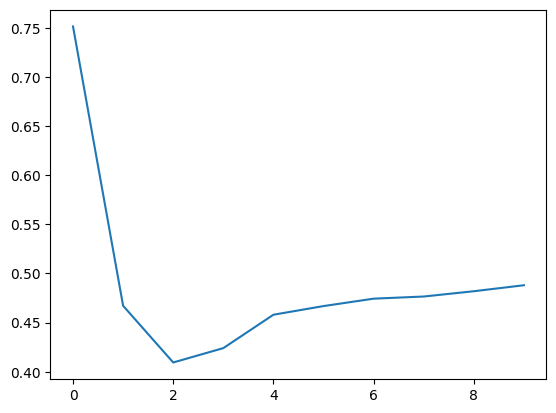

In [14]:
plt.plot(epoch_vl_loss)


In [ ]:
def predict(sentence, model, tweet_corpus, max_len):
    sentence = sentence.lower()
    words = sentence.split(" ")
    corpus_dict = corpora.Dictionary([tweet_corpus]).token2id
    tokens = [corpus_dict[x] for x in words if x in corpus_dict]
    if len(tokens) <= 1:
        print("No Valid Strings!")
        return None
    else:
        tokens = np.array(tokens)

    if len(tokens) < max_len:
        tokens = np.append(tokens, [0]*(max_len - len(tokens)))
        tokens = tokens[0:max_len]
    
    tokens = torch.LongTensor(tokens[None, :])
    tokens = tokens.to(device)
    output = model(tokens)
    preds = torch.argmax(output, 1)
    return preds
    

In [32]:
predict("I like cheese", model, train_corpus, 35)


tensor([1], device='cuda:0')